In [0]:
# README: Run in Google Colab...

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Data Loading|
url = '/content/drive/My Drive/Colab Notebooks/US_trending.pkl'
videos_df = pd.read_pickle(url)

In [3]:
# Data Preprocessing
videos_df.dropna(inplace=True, subset=['description'])

def filter_stopwords(text):
    text = text.lower()
    word_list = nltk.word_tokenize(text)
    filtered_words = [word for word in word_list if word not in STOPWORDS]
    return ' '.join(filtered_words)

# Make X (video titles) and y (video categories) vectors
video_descriptions = videos_df['description'].apply(lambda var: filter_stopwords(var))

category_dummies = pd.get_dummies(videos_df['category_name'])
categories = list(category_dummies.columns)
labels = category_dummies.values
print('Shape of label tensor:', labels.shape)
categories_num = labels.shape[1]

for i in range(0, 10):
    print(video_descriptions[i])

Shape of label tensor: (3510, 15)
late late show guest host harry styles challenges kendall jenner game spill guts fill guts , two ask personal questions face choice : answer truthfully eat whatever front . cod sperm salmon smoothie force spill guts ? late late show : subscribe : http : //bit.ly/cordenyoutubewatch full episodes : http : //bit.ly/1enypw4facebook : http : //on.fb.me/19pihlctwitter : http : //bit.ly/1iv0q6kinstagram : http : //bit.ly/latelategramwatch late late show james corden weeknights 12:35 et/11:35 pm ct. cbs.get new episodes shows love across devices next day , stream live tv , watch full seasons cbs fan favorites anytime , anywhere cbs access . try free ! http : //bit.ly/1oqa29b -- -each week night , late late show james corden throws ultimate late night party mix celebrity guests , edgy musical acts , games sketches . corden differentiates show offering viewers peek behind-the-scenes green room , bringing guests lending musical acting talents various sketches . a

In [0]:
# Preparing data as sequences for LSTM
# Hyperparameters
vocab_size = 8000
embedding_dim = 128
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [5]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(video_descriptions, labels, test_size=0.20, random_state=33)
print('X_train length: {}'.format(len(X_train)))
print('y_train length: {}'.format(len(y_train)))
print('X_test length: {}'.format(len(X_test)))
print('y_test length: {}'.format(len(y_test)))

X_train length: 2808
y_train length: 2808
X_test length: 702
y_test length: 702


In [6]:
# Find vocab_size (5000) most common words, and replace all other words with oov_tok (<OOV>)
# POTERAJ JEDNOM BEZ OVOG OOV_TOKEN DA VIDIS HOCE LI TAD BITI BOLJE! Mislim da je nepotrebno kad koristim word2vec
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

# Turn tokens into list of sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[10])

lengths = []
for seq in train_sequences:
    lengths.append(len(seq))

print('Maximum length of sequences: {}'.format(max(lengths)))

# Padding - make sequences of same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

[6394, 240, 2, 7282, 120, 12, 3, 1, 2, 3, 5, 1, 551, 3289, 614, 3699, 991]
Maximum length of sequences: 623
16
300
17
300
17
300


In [7]:
# Same job for test (validation) set
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(test_padded.shape)

(702, 300)


In [8]:
# Word2Vec Model (pretrained on Google News dataset)
word2vec_path = '/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

w2v_weights = w2v_model.vectors
vocab_len, embedding_size = w2v_weights.shape

# model test
#w2v_model.most_similar(positive=['woman', 'king'], negative=['man'])

#w2v_model = gensim.models.Word2Vec(video_descriptions, size=100, window=5, min_count=3, workers=4)

def word2token(word):
    try:
        return w2v_model.vocab[word].index
    except KeyError:
        return 0
    
def token2word(token):
    return w2v_model.index2word[token]

# test
token = word2token('news')
word = token2word(token)
print(word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


news


In [0]:
# Create CNN with Embedding layer using weights from word2vec trained on Google News dataset
# PROBAJ I SA TRENIRANJEM EMBEDDING SLOJA (IMAS LINK SA TIME NA MEJLU...)
sequence_length = train_padded.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.2

def create_model_CNN():
  # Input layer
  inputs = Input(shape=(sequence_length, ))

  # Embedding layer
  embedding = Embedding(input_dim=vocab_len,
                        output_dim=embedding_size,
                        weights=[w2v_weights],
                        input_length=max_length,
                        trainable=False)(inputs)
  # Reshape layer
  reshape = Reshape((sequence_length, 300, 1))(embedding)

  # Convolution layers
  conv_0 = Conv2D(num_filters, (filter_sizes[0], embedding_size), activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_1 = Conv2D(num_filters, (filter_sizes[1], embedding_size), activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_2 = Conv2D(num_filters, (filter_sizes[2], embedding_size), activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)

  # Max Pooling layers
  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  reshape = Reshape((3*num_filters,))(flatten)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=categories_num, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

  model = Model(inputs, output)
  return model

In [14]:
# Compile and train model
model = create_model_CNN()

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

history = model.fit(train_padded, y_train, batch_size=1000, epochs=200, validation_data=(test_padded, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 2808 samples, validate on 702 samples
Epoch 1/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.8615 - acc: 0.2012 - val_loss: 2.5800 - val_acc: 0.3034
Epoch 2/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.5548 - acc: 0.2945 - val_loss: 2.4488 - val_acc: 0.3234
Epoch 3/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.4338 - acc: 0.3273 - val_loss: 2.3635 - val_acc: 0.3832
Epoch 4/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.3394 - acc: 0.4006 - val_loss: 2.2967 - val_acc: 0.4117
Epoch 5/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.2662 - acc: 0.4384 - val_loss: 2.2356 - val_acc: 0.4188
Epoch 6/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.2000 - acc: 0.4306 - val_loss: 2.1922 - val_acc: 0.4174
Epoch 7/200
2808/2808 [==============================] - 19s 7ms/step - loss: 2.1476 - acc: 0.4441 - val_loss: 2.1553 - val_acc: 0.4416
E

In [15]:
accr = model.evaluate(test_padded, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

702/702 [==============================] - 2s 2ms/step
Test set
  Loss: 1.746
  Accuracy: 0.754


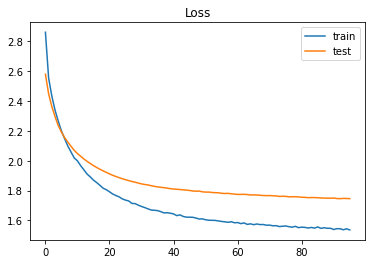

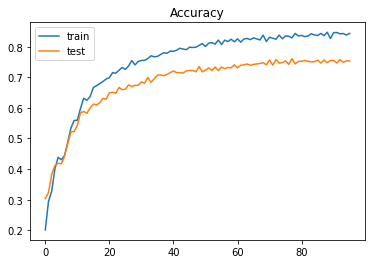

In [16]:
# Visualization
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();